<a href="https://colab.research.google.com/github/sejin-sim/Practical_statistics/blob/main/7_%EB%B9%84%EC%A7%80%EB%8F%84%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 셋팅

In [31]:
! pip install prince
! pip install gower

import math
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal

import prince

import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
import seaborn as sns

import gower


! git clone https://github.com/gedeck/practical-statistics-for-data-scientists.git
! cp -r /content/practical-statistics-for-data-scientists/data /content/data

try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'


fatal: destination path 'practical-statistics-for-data-scientists' already exists and is not an empty directory.


In [32]:
SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'
SP500_SECTORS_CSV = DATA / 'sp500_sectors.csv'
LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'
HOUSE_TASKS_CSV = DATA / 'housetasks.csv'

- 비지도 학습 : 레이블이 달린 데이터를 이용해 모델을 학습하는 과정 없이 데이터로부터 의미를 이끌어내는 통계적 기법

 ex. 클러스터링, 차원을 줄이는 것, 콜드스타트(cold-start : 시스템이 아직 충분한 정보를 수집하지 않은 사용자 나 항목에 대한 추론을 도출 할 수없는 때)

# 1. 주성분 분석

- 주성분 분석 : 수치형 변수가 어떤 식으로 공변하는지 알아내는 기법으로 다수의 수치형 예측 변수들을 더 적은 수의 변수들의 집합으로 나타내는 것

- 주성분 : 전체 변수들의 변동성을 거의 대부분 설명할 수 있는 적은 수의 변수들의 집합이다. 수치형 예측변수들의 선형결합니다.

### 1. 간단한 예제 : 주가 수익 데이터에 pca 적용

In [33]:
sp500_px = pd.read_csv(SP500_DATA_CSV, index_col=0)
oil_px = sp500_px[['XOM', 'CVX']] 
print('주가 수익 변동성')
print(oil_px.head())

주가 수익 변동성
                 XOM       CVX
1993-01-29 -0.016991  0.072921
1993-02-01  0.016991  0.102089
1993-02-02  0.084954  0.029168
1993-02-03  0.067964  0.058337
1993-02-04  0.034378  0.044272


In [34]:
pcs = PCA(n_components=2) # 주성분을 2개로 설정
pcs.fit(oil_px)
loadings = pd.DataFrame(pcs.components_, columns=oil_px.columns)
print(loadings)

        XOM       CVX
0 -0.664711 -0.747101
1  0.747101 -0.664711


- 첫번째 주성분의 가중치 각각 -0.664711 -0.747101 : 석유 회사 사이의 상관관계를 반영하는 평균을 의미
- 두번째 주성분의 가중치 각각 0.747101 -0.664711 : 주가가 달라지는 지점

CVX와 XOM의 주가 수익에 대한 주성분 분석


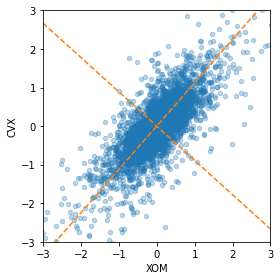

In [35]:
def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

ax = oil_px.plot.scatter(x='XOM', y='CVX', alpha=0.3, figsize=(4, 4))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.plot(*abline(loadings.loc[0, 'CVX'] / loadings.loc[0, 'XOM'], 0, ax),
        '--', color='C1')
ax.plot(*abline(loadings.loc[1, 'CVX'] / loadings.loc[1, 'XOM'], 0, ax),
        '--', color='C1')

print('CVX와 XOM의 주가 수익에 대한 주성분 분석')
plt.tight_layout()
plt.show()

- 첫번째 선(타원의 장축) : 두 주가 수익의 대부분의 변동성

### 2. 주성분 계산

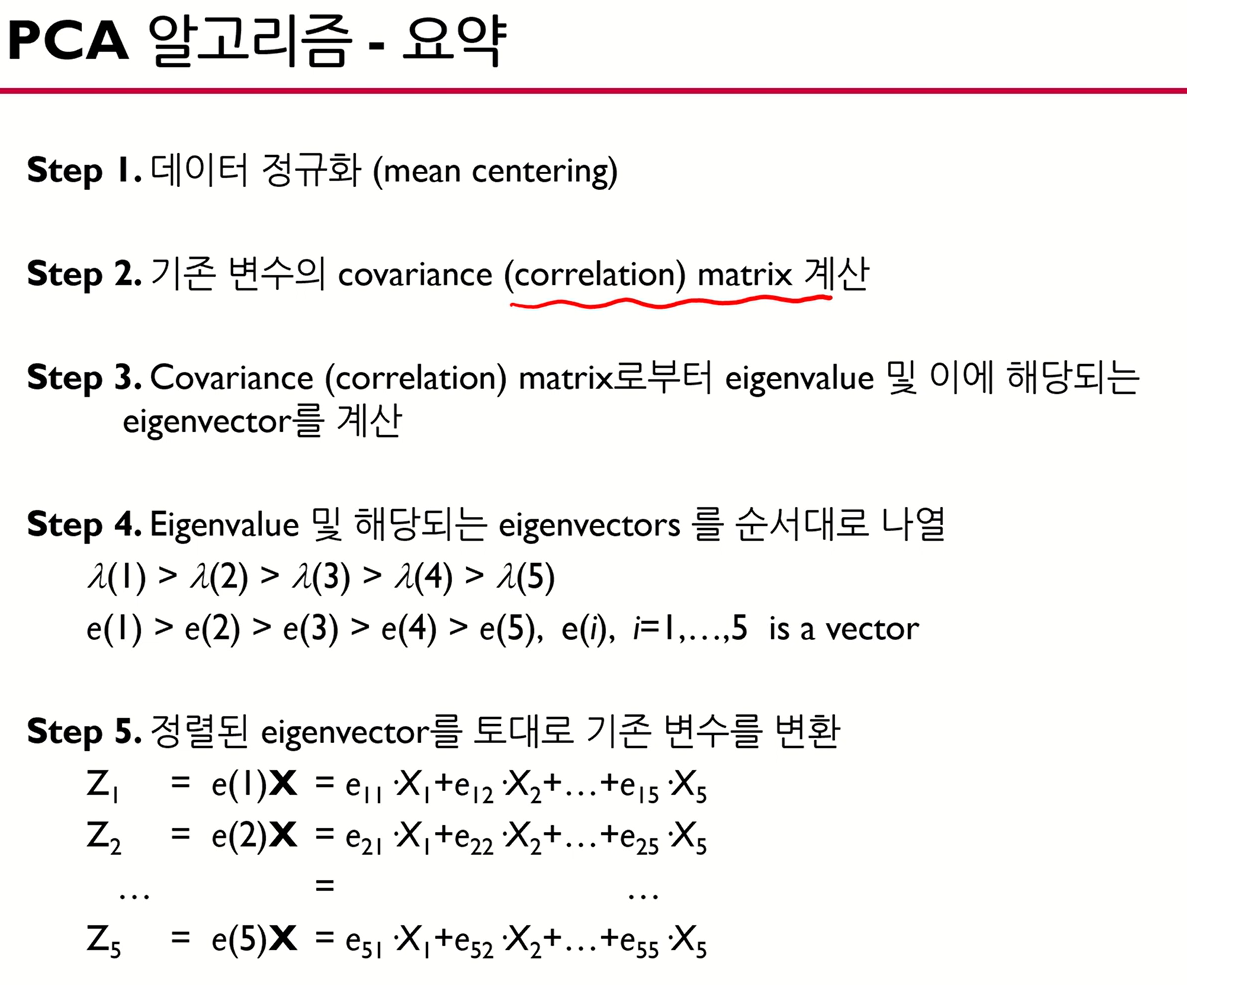

# 3. 주성분 해석

- 스크리그래프 ; 주성분의 상대적인 중요도를 표시해주는 시각화 방법

S&P 500 상위권 주가에 대한 PCA의 스크리그래프


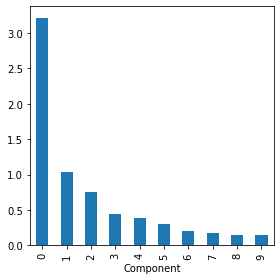

In [36]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',
        'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]

sp_pca = PCA()
sp_pca.fit(top_sp)

explained_variance = pd.DataFrame(sp_pca.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

print('S&P 500 상위권 주가에 대한 PCA의 스크리그래프')
plt.tight_layout()
plt.show()

주가 수익의 상위 다섯 개 주성분에 대한 부하


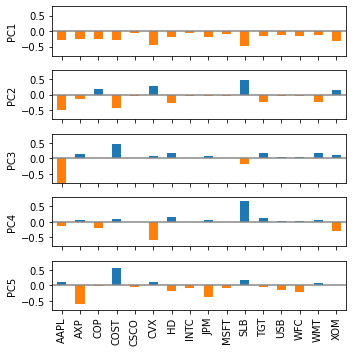

In [37]:
loadings = pd.DataFrame(sp_pca.components_[0:5, :], 
                        columns=top_sp.columns)

maxPC = 1.01 * np.max(np.max(np.abs(loadings.loc[0:5, :])))

f, axes = plt.subplots(5, 1, figsize=(5, 5), sharex=True)

for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)

print('주가 수익의 상위 다섯 개 주성분에 대한 부하')
plt.tight_layout()
plt.show()

- 첫번째 주 성분의 경우 전반적인 주식시장의 흐름에 영향을 받는 것으로 해석할 수 있다.
- 두반째 주 성분의 경우 에너지 관련 주식들만 가격 변동을 잡아 낸다.
- 세번째 주성분의 경우 애플과 코스트코의 움직임이 서로 반대라는 사실을 보여준다.
- 네번째 주성분의 경우 술룸베르거와 나머지 에너지 회사들의 움직임이 반대라는 것을 보여준다.
- 다섯번째 주성분의 경우 금융회사들이 주를 이루고 있다.


### 4. 대응분석

- 범주형 데이터에서 범주간 혹은 범주형 피처 간의 연관성을 인식하는 것

집안 일 데이터의 대응분석 결과를 그래프로 표현


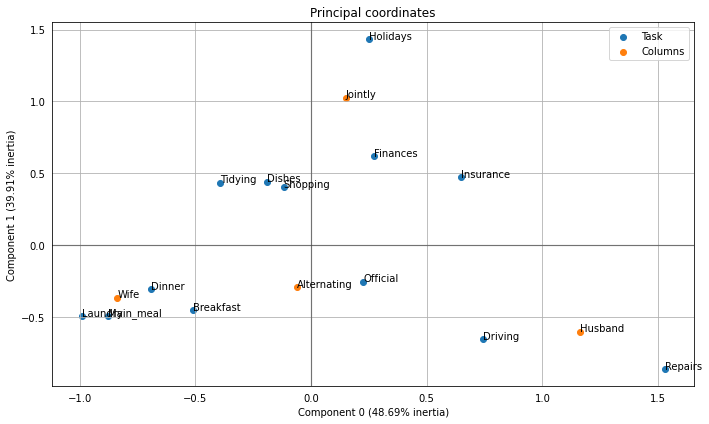

In [38]:
housetasks = pd.read_csv(HOUSE_TASKS_CSV, index_col=0)

ca = prince.CA(n_components=2)
ca = ca.fit(housetasks)

ca.plot_coordinates(housetasks, figsize=(10, 6))

print('집안 일 데이터의 대응분석 결과를 그래프로 표현')
plt.tight_layout()
plt.show()

# 2. k-평균 클러스터링

- 클러스터링(군집화) : 데이터를 서로 다른 그룹으로 분류하는 기술

- k-means : 최초로 개발된 클러스터링 기법. 간단하고 손쉽게 사용가능

- k-mean는 데이터를 k개의 클러스터로 나누며, 이때 할당된 클러스트의 평균과 포함된 데이터들의 거리 제곱합이 최소가 되게 한다.

  : 클러스터 내 제곱합 = 클러스터 내 SS

### 1. 간단한 예제

- 핏쳐(변수)가 $x,y$ 2개이고, 레코드가 $n$개인 데이터를 k=4 클러스터로 분할을 가정

  ## $ \bar{x}_{k} = \frac{1}{n_k} \sum_{i \in \text{k}}^{} {x_i} $

  ## $ \bar{y}_{k} = \frac{1}{n_k} \sum_{i \in \text{k}}^{} {y_i} $

  - $ \bar{x}_{k}, \bar{y}_{k} $ : 클러스터의 중심으로 클러스터내에 존재하는 점들의 평균을 의미

  ## $SS_k = \sum_{i \in \text{k}}^{} (x_i - \bar{x}_k)^2 + (y_i - \bar{y}_k)^2 $

  - k-평균은 클러스터 내부의 제곱합이 최소가 되게 레코드 들을 클러스터에 할당한다.


In [39]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
kmeans = KMeans(n_clusters=4).fit(df)
df['cluster'] = kmeans.labels_
print(df.head())

                 XOM       CVX  cluster
2011-01-03  0.736805  0.240681        2
2011-01-04  0.168668 -0.584516        1
2011-01-05  0.026631  0.446985        2
2011-01-06  0.248558 -0.919751        1
2011-01-07  0.337329  0.180511        2


In [40]:
print('각 클러스터의 평균')
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['XOM', 'CVX'])
print(centers)

각 클러스터의 평균
        XOM       CVX
0 -1.143980 -1.750297
1 -0.328486 -0.566914
2  0.241016  0.334213
3  0.956863  1.370889


- 클러스터 1,3 : 하락장
- 클러스터 0,2 : 상승장을 의미한다.

클러스터 시각화


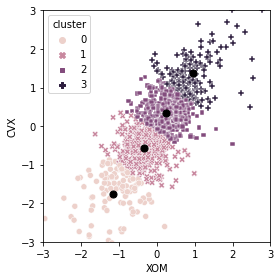

In [41]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.scatterplot(x='XOM', y='CVX', hue='cluster', style='cluster', 
                     ax=ax, data=df)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
centers.plot.scatter(x='XOM', y='CVX', ax=ax, s=50, color='black')

print('클러스터 시각화')
plt.tight_layout()
plt.show()

- k-평군은 클러스터가 잘 분리되지 않는 경우에도 어떻게든 레코드를 클러스터에 할당한다.

### 2. k-평균 알고리즘

- 사용자가 미리 정해준 k값과 클러스터 평균의 초깃값을 가지고 알고리즘을 시작하며, 각 레코드에 대한 클러스터 할당이 더는 변화하지 않을 때 알고리즘이 수렴했다고 볼 수 있다.

- 반복 루프를 통해 k-평균은 클러스터 내 제곱합이 최소가 되도록 하는 해를 얻게 된다.

In [42]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP', 
               'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]
kmeans = KMeans(n_clusters=5).fit(top_sp) # 기본적으로 10번 반복되며 max 300

### 3. 클러스터 해석

- k-평균에서 가장 중요한 두 출력은 클러스터의 크기와 클러스터의 평균이다.



In [43]:
from collections import Counter

print('앞에서 구한 클러스터의 평균 : ')
print(Counter(kmeans.labels_))
# 비교적 균일함을 볼 수 있다.

앞에서 구한 클러스터의 평균 : 
Counter({4: 290, 0: 286, 1: 273, 2: 175, 3: 107})


- 유난히 균형이 맞지 않는 클러스터가 존재한다면, 좀 더 자세히 들여다 볼 수가 있다.

클러스터에서 변수들의 평균(클러스터 평균)


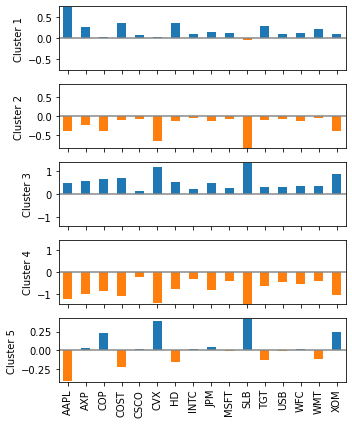

In [44]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=syms)

f, axes = plt.subplots(5, 1, figsize=(5, 6), sharex=True)
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.01 * np.max(np.max(np.abs(center)))
    colors = ['C0' if l > 0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i + 1}')
    ax.set_ylim(-maxPC, maxPC)

print('클러스터에서 변수들의 평균(클러스터 평균)')
plt.tight_layout()
plt.show()

- 클러스터 1,2의 경우 각각 주식시장이 내리고 오른 날을 의미
- 클러스터 3,5의 경우 각각 에너지 관련 주식이 내린 날과 소비재 주식이 오른 날의 특징을 보여 줌
- 클러스터 4은 에너지 주식이 오르고 소비재 주식이 내린 날을 보여준다.

### 4. 클러스터 개수 선정

- 클러스터의 개수를 미리 결정하기 어려울 경우 통계적 접근 방식을 사용할 수 있지만, 최상의 클러스터 개수를 차즌ㄴ 한 가지의 표준화된 방법은 없다.

- 팔꿈치 방법 : 언제 클러스터 세트가 데이터의 분산의 대부분을 설명하는지를 알려준다. 누적 분산이 가파르게 상승한 다음 어느 순간 평평하게 되는 지점을 팔꿈치 지점이라고 한다.

- 예제 : 클러스터 개수에 따른 주식 데이터에 대해 수렴된 분산의 누적 백분율

주식데이터에 적용한 팔꿈치 방법


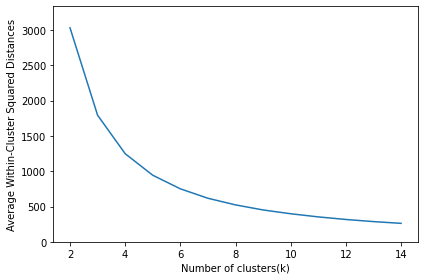

In [45]:
inertia = []
for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(top_sp)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(2, 15), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)

print('주식데이터에 적용한 팔꿈치 방법')
plt.tight_layout()
plt.show()

# 3. 계층적 클러스터링

- 계층적클러스터링 : k-평균 대신 사용하는 클러스터링 방법으로 k-평균과는 아주 다른 결과를 보여준다. 특이점이나 비정상적인 그룹이나 레코드를 발견하는 데 더 민감하다.

  - 컴퓨터 리소스가 많이 들기 때문에 대규모 데이터셋에는 적용할 수 없다. 

### 1. 간단한 예제

- 계층적 클러스터링은 각 레코드 자체를 개별 클러스터로 설정하여 시작하고, 가장 가까운 클러스터를 결합해나가는 작업을 반복한다.

In [46]:
syms1 = ['AAPL', 'AMZN', 'AXP', 'COP', 'COST', 'CSCO', 'CVX', 'GOOGL', 'HD', 
         'INTC', 'JPM', 'MSFT', 'SLB', 'TGT', 'USB', 'WFC', 'WMT', 'XOM']
df = sp500_px.loc[sp500_px.index >= '2011-01-01', syms1].transpose()

#  linkage : 두 클러스터상에서 가장 먼 거리를 이용해서 측정하는 방식
Z = linkage(df, method='complete')
print(Z.shape)

(17, 4)


### 2. 덴드로그램(Dendrogram)

- 덴드로그램 : 트리 모델과 같이 자연스러운 시각적 표현

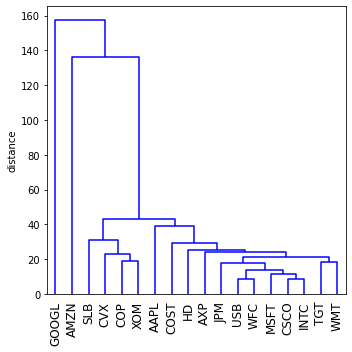

In [47]:
fig, ax = plt.subplots(figsize=(5, 5))
dendrogram(Z, labels=list(df.index), color_threshold=0)
plt.xticks(rotation=90)
ax.set_ylabel('distance')

plt.tight_layout()
plt.show()

- 트리의 잎은 각 레코드를 의미하며, 가지 길이는 해당 클러스터 간의 차이 정도를 나타낸다.

- 구글과 아마존에 대한 수익률은 서로 다르고 다른 주식에 대한 수익률도 상당히 다른것을 볼 수 있다.

- 석유관련주들은 자신들의 클러스터가 있고 애플은 독자적이고 나머지는 서로 비슷하다.

In [48]:
memb = fcluster(Z, 4, criterion='maxclust')
memb = pd.Series(memb, index=df.index)
for key, item in memb.groupby(memb):
    print(f"{key} : {', '.join(item.index)}")

1 : COP, CVX, SLB, XOM
2 : AAPL, AXP, COST, CSCO, HD, INTC, JPM, MSFT, TGT, USB, WFC, WMT
3 : AMZN
4 : GOOGL


- 클러스터의 개수가 4개로 설정되어 있고, 구글과 아마존은 독자적임을 알 수 있다.

### 3. 병합알고리즘

- 병합 알고리즘 : 유사한 클러스터들을 반복적으로 병합하는 역할을 한다. 단일 레코드로 구성된 클러스터에서 시작하여 점점 더 큰 클러스터들을 만든다.

- 비유사도 측정방법 : A,B 사이의 모든 레코드 쌍의 최대 거리를 사용하는 완전 연결 방식

  $D(A,B) = max d(a_i, b_j)$ 모든 i,j 쌍에 대해 비유사도를 계신

- 지표 : 완전연결, 단일연결, 평균연결, 최소분산, 워드기법

- 예시 : 주식데이터에 대해 비유사도를 4가지 지표로 측정

주식 데이터에 대한 비유사도 측정 지표 간 비교


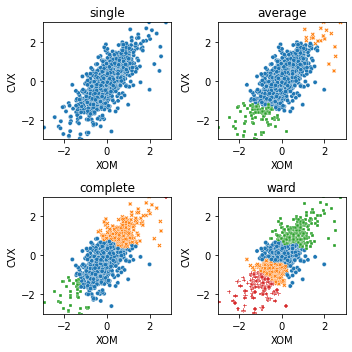

In [49]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
for i, method in enumerate(['single', 'average', 'complete', 'ward']):
    ax = axes[i // 2, i % 2]
    Z = linkage(df, method=method)
    colors = [f'C{c+1}' for c in fcluster(Z, 4, criterion='maxclust')]
    ax = sns.scatterplot(x='XOM', y='CVX', hue=colors, style=colors,
                         size=0.5, ax=ax, data=df, legend=False)

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_title(method)

print('주식 데이터에 대한 비유사도 측정 지표 간 비교')
plt.tight_layout()
plt.show()

# 4. 모델 기반 클러스터링

- 모델 기반 클러스터링 : 통계 이론에 기초하고 있으며 클러스터의 성질과 수를 결정하는 더 엄격한 방법을 제공한다.

### 1. 다변량정규분포 

- 다변량정규분포 : p개의 변수 집합에 대해 정규 분포를 일반화 한 것이다. 

- 분포는 평균집한과 공분산행렬로 정의 된다.

- 공분산행렬은 변수가 서로 어떻게 상호 관련되어 있는지를 나타내는 지표이다. 

2차원 정규분포에 대한 확률 등고선


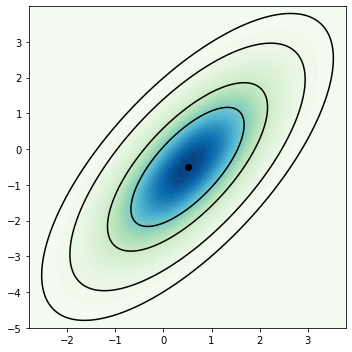

In [51]:
mean = [0.5, -0.5]
cov = [[1, 1], [1, 2]]
probability = [.5, .75, .95, .99]
def probLevel(p):
    D = 1
    return (1 - p) / (2 * math.pi * D)
levels = [probLevel(p) for p in probability]

fig, ax = plt.subplots(figsize=(5, 5))

x, y = np.mgrid[-2.8:3.8:.01, -5:4:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(mean, cov)


CS = ax.contourf(x, y, rv.pdf(pos), cmap=cm.GnBu, levels=50)
ax.contour(CS, levels=levels, colors=['black'])
ax.plot(*mean, color='black', marker='o')

print('2차원 정규분포에 대한 확률 등고선')
plt.tight_layout()
plt.show()

### 2. 정규혼합

- 각 레코드가 k개의 다변량정규분포 중 하나로부터 발생했다고 가정하는 것
- 서로 다른 평균 $\mu$와 공분산행렬 $\sum$을 갖는다.
- 각 행은 $k$개의 다변량 정규분포 중 하나에서 샘플링 된 것으로 모델링 된다.

In [53]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
mclust = GaussianMixture(n_components=2).fit(df)
print(mclust.bic(df))

4590.064133153184


mclust를 사용하여 주가 수익 데이터에 대해 두 개의 클러스터를 얻는다.


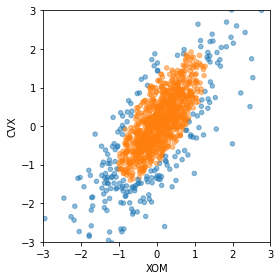

In [56]:
fig, ax = plt.subplots(figsize=(4, 4))
colors = [f'C{c}' for c in mclust.predict(df)]
df.plot.scatter(x='XOM', y='CVX', c=colors, alpha=0.5, ax=ax)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

print('mclust를 사용하여 주가 수익 데이터에 대해 두 개의 클러스터를 얻는다.')
plt.tight_layout()
plt.show()

In [57]:
print('정규분포의 파라미터를 추출')
print('Mean')
print(mclust.means_)
print('Covariances')
print(mclust.covariances_)

정규분포의 파라미터를 추출
Mean
[[-0.05027639 -0.21089398]
 [ 0.07283435  0.10555253]]
Covariances
[[[0.96798717 0.97429323]
  [0.97429323 1.66712807]]

 [[0.26770716 0.27513521]
  [0.27513521 0.51587914]]]


### 3. 클러스터 개수 결정하기

- 베이즈정보기준(BIC) 값이 가장 큰 클러스터의 개수를 선택하여 동작하도록 함

서로 다른수의 클러스터에 따른 주가 수익 데이터에 대한 모델의 BIC 점수


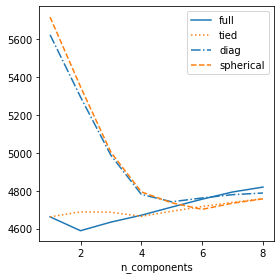

In [59]:
results = []
covariance_types = ['full', 'tied', 'diag', 'spherical']
for n_components in range(1, 9):
    for covariance_type in covariance_types:
        mclust = GaussianMixture(n_components = n_components, warm_start=True,
                                 covariance_type = covariance_type)
        mclust.fit(df)
        results.append({
            'bic': mclust.bic(df),
            'n_components': n_components,
            'covariance_type': covariance_type,
        })
        
results = pd.DataFrame(results)

colors = ['C0', 'C1', 'C2', 'C3']
styles = ['C0-','C1:','C0-.', 'C1--']

fig, ax = plt.subplots(figsize=(4, 4))
for i, covariance_type in enumerate(covariance_types):
    subset = results.loc[results.covariance_type == covariance_type, :]
    subset.plot(x='n_components', y='bic', ax=ax, label=covariance_type, 
                kind='line', style=styles[i]) # , color=colors[i])

print('서로 다른수의 클러스터에 따른 주가 수익 데이터에 대한 모델의 BIC 점수')
plt.tight_layout()
plt.show()

- 서로 다른 모델을 피팅하고 최적의 모델을 자동으로 선택한다.

# 5. 스케일링과 범주형 변수

- 데이터의 적절한 스케일이 필요

### 1. 변수 스케일링

- 예시 : 대출데이터를 정규화하지 않고 바로 kmeans 함수 적용

In [62]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)
defaults = loan_data.loc[loan_data['outcome'] == 'default',]

columns = ['loan_amnt', 'annual_inc', 'revol_bal', 'open_acc', 
           'dti', 'revol_util']

df = defaults[columns]
kmeans = KMeans(n_clusters=4, random_state=1).fit(df)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=columns)
centers['size'] = [counts[i] for i in range(4)]
print('정규화 전')
print(centers)

정규화 전
      loan_amnt     annual_inc     revol_bal  ...        dti  revol_util   size
0  18275.132345   83354.634595  19635.189254  ...  16.774586   62.258588   7543
1  21852.701005  165407.730318  38907.295645  ...  13.466876   63.634900   1194
2  10591.893792   42453.058692  10268.048598  ...  17.713563   58.111226  13882
3  22570.192308  489783.403846  85161.346154  ...   6.907500   59.651923     52

[4 rows x 7 columns]


- annual_inc, revol_bal이 결과를 좌우하며, 클러스터 1은 52명의 데이터만 포함되어 있는 불균형 현상이 생긴다.

In [63]:
scaler = preprocessing.StandardScaler()
df0 = scaler.fit_transform(df * 1.0)

kmeans = KMeans(n_clusters=4, random_state=1).fit(df0)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                       columns=columns)
centers['size'] = [counts[i] for i in range(4)]
print('정규화 후')
print(centers)

정규화 후
      loan_amnt     annual_inc     revol_bal  ...        dti  revol_util  size
0  10499.824632   51070.958451  11629.172535  ...  15.965747   77.806693  7405
1  10315.255666   53468.181307   6032.616033  ...  11.255855   31.000342  5339
2  25920.260952  116308.326663  32827.641428  ...  16.204021   66.172004  3701
3  13420.700048   55844.852918  16370.832021  ...  24.189881   59.227862  6226

[4 rows x 7 columns]


- 클러스터들의 크기가 좀 더 균일해졌다. 

### 2. 지배 변수
- 1.의 예제에서 구글과 아마존의 주가 정보를 추가한다고 가정

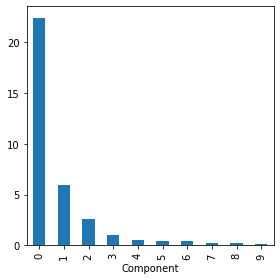

In [64]:
syms = ['GOOGL', 'AMZN', 'AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 
        'SLB', 'COP', 'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST']
top_sp1 = sp500_px.loc[sp500_px.index >= '2005-01-01', syms]

sp_pca1 = PCA()
sp_pca1.fit(top_sp1)

explained_variance = pd.DataFrame(sp_pca1.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

In [65]:
loadings = pd.DataFrame(sp_pca1.components_[0:2, :], 
                        columns=top_sp1.columns)
print(loadings.transpose())

              0         1
GOOGL -0.857310  0.477873
AMZN  -0.444728 -0.874149
AAPL  -0.071627 -0.020802
MSFT  -0.036002 -0.006204
CSCO  -0.029205 -0.003045
INTC  -0.026666 -0.006069
CVX   -0.089548 -0.037420
XOM   -0.080336 -0.020511
SLB   -0.110218 -0.030356
COP   -0.057739 -0.024117
JPM   -0.071228 -0.009244
WFC   -0.053228 -0.008597
USB   -0.041670 -0.005952
AXP   -0.078907 -0.024027
WMT   -0.040346 -0.007141
TGT   -0.063659 -0.024662
HD    -0.051412 -0.032922
COST  -0.071403 -0.033826


- 두 개의 변수가 전체 부하량을 지배한다는 것을 볼 수 있다. (구글과 아마존)

### 3. 범주형 데이터와 고워 거리

- 범주형 데이터의 경우 순서형 또는 이진형 변수를 사용하여 수치형 데이터로 변환해야 한다.

- 고워 거리 : 각 변수의 데이터 유형에 따라 거리 지표를 다르게 적용
  1. 수치형, 순서형 : 레코드 간의 거리를 맨해튼 거리로 계산
  2. 범주형 : 범주가 다르면 거리가 1이고, 범주가 동일하면 거리는 0이다.

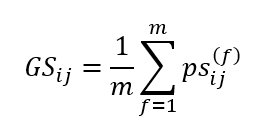



In [72]:
x = defaults[['dti', 'payment_inc_ratio', 'home_', 'purpose_']].loc[0:4, :]
print('대출 데이터의 일부')
print(x)

대출 데이터의 일부
     dti  payment_inc_ratio home_            purpose_
0   1.00            2.39320  RENT      major_purchase
1   5.55            4.57170   OWN      small_business
2  18.08            9.71600  RENT               other
3  10.08           12.21520  RENT  debt_consolidation
4   7.06            3.90888  RENT               other


In [73]:
distance_matrix = gower.gower_matrix(x)
print('고워 거리 계산')
display(distance_matrix)

고워 거리 계산


array([[0.        , 0.62204784, 0.6863877 , 0.632904  , 0.37727892],
       [0.62204784, 0.        , 0.8143398 , 0.7608561 , 0.5389727 ],
       [0.6863877 , 0.8143398 , 0.        , 0.43070832, 0.30910876],
       [0.632904  , 0.7608561 , 0.43070832, 0.        , 0.505625  ],
       [0.37727892, 0.5389727 , 0.30910876, 0.505625  , 0.        ]],
      dtype=float32)

- 가장 거리가 먼 : 0.8143398 2번과 3번의 레코드
- 가장 거리가 가까운 : 0.30910876 5번과 3번의 레코드

### 4. 혼힙 데이터의 클러스터링 문제

- 이진형 데이터에서는 k-평균과 PCA를 사용하는 것이 어려울 수 있다. 0/1 변수의 경우 0 또는 1의 값인 레코드가 모두 한 클러스터에 포함되기 때문

  → K-평균에서 클러스터 내 제곱합이 작아진다.

In [75]:
columns = ['dti', 'payment_inc_ratio', 'home_', 'pub_rec_zero']
df = pd.get_dummies(defaults[columns])

scaler = preprocessing.StandardScaler()

df0 = scaler.fit_transform(df * 1.0)
kmeans = KMeans(n_clusters=4, random_state=1).fit(df0)
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                       columns=df.columns)

print('상위 4개 클러스터가 요인변수들과 밀접한 관련이 있음')
print(centers)

상위 4개 클러스터가 요인변수들과 밀접한 관련이 있음
         dti  payment_inc_ratio  ...     home__OWN    home__RENT
0  16.992128           9.105395  ... -2.012279e-15  1.000000e+00
1  17.456244           8.422914  ...  3.053113e-16 -1.304512e-14
2  16.504955           8.064247  ... -9.159340e-16  4.843400e-01
3  17.197993           9.266666  ...  1.000000e+00 -5.273559e-15

[4 rows x 6 columns]


- 이를 해결 하기 위해 이진형 변수의 크기를 다른 변수들보다 작은 값으로 조정할 수 있음
- 또는 특정 범주 값에 따라 서로 다른 하위 집합에 클러스터링을 적용할 수도 있음